In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Carga de datos

In [27]:
data_dir = "../data/"
df = pd.read_csv(f"{data_dir}/aptos_bogota_cleaned.csv")  

In [28]:
# Variables a eliminar por demasiados nulos
cols_to_drop = ["area_terraza", "numero_piso", "numero_closets"]
df = df.drop(columns=cols_to_drop)

In [29]:
# Definir variable objetivo y features
y = df["precio_venta"]
X = df.drop(columns=["precio_venta"])

# Identificar tipos de variables
num_features = ["area", "habitaciones", "banos", "administracion", "parqueaderos", "estrato", "latitud", "longitud"]
cat_features = ["sector", "estado", "antiguedad"]
binary_features = ["alarma", "ascensor", "conjunto_cerrado", "gimnasio", "piscina", "zona_de_bbq"]

# Separar conjunto de validación final
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42)

## Pipeline

In [30]:
# Preprocesadores
num_transformer = SimpleImputer(strategy="median")
cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="desconocido")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
        ("bin", "passthrough", binary_features)
    ]
)

# Pipeline completo
model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(random_state=42, n_jobs=-1))
])



In [31]:
# Validación cruzada sobre el conjunto de entrenamiento
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [32]:


rmse_scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_root_mean_squared_error")
mae_scores = -cross_val_score(model, X_train, y_train, cv=kf, scoring="neg_mean_absolute_error")
r2_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring="r2")

print("\n===== Validación cruzada (k=5) =====")
print(f"RMSE promedio: {rmse_scores.mean():,.0f}")
print(f"MAE promedio: {mae_scores.mean():,.0f}")
print(f"R² promedio: {r2_scores.mean():.3f}")



===== Validación cruzada (k=5) =====
RMSE promedio: 249,679,162
MAE promedio: 137,957,658
R² promedio: 0.917


In [33]:

# Entrenar modelo final y evaluar en el conjunto de validación final
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
y_pred = model.predict(X_val)

rmse_final = mean_squared_error(y_val, y_pred)
mae_final = mean_absolute_error(y_val, y_pred)
r2_final = r2_score(y_val, y_pred)

print("\n===== Evaluación en conjunto de validación final =====")
print(f"RMSE: {rmse_final:,.0f}")
print(f"MAE: {mae_final:,.0f}")
print(f"R²: {r2_final:.3f}")



===== Evaluación en conjunto de validación final =====
RMSE: 60,842,327,057,650,080
MAE: 137,791,054
R²: 0.916


In [35]:
print(y_val.describe())
print(pd.Series(y_pred).describe())

count    4.106000e+03
mean     9.961398e+08
std      8.532713e+08
min      8.100000e+07
25%      4.185000e+08
50%      7.000000e+08
75%      1.300000e+09
max      5.400000e+09
Name: precio_venta, dtype: float64
count    4.106000e+03
mean     1.004339e+09
std      8.368261e+08
min      9.977772e+07
25%      4.233180e+08
50%      7.174369e+08
75%      1.336107e+09
max      5.028902e+09
dtype: float64


In [36]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# convertir ambos a arrays para asegurar alineación
y_true = np.array(y_val)
y_pred = np.array(y_pred)

rmse_final = np.sqrt(np.mean((y_true - y_pred) ** 2))
mae_final = np.mean(np.abs(y_true - y_pred))
r2_final = r2_score(y_true, y_pred)

print(f"RMSE: {rmse_final:,.0f}")
print(f"MAE: {mae_final:,.0f}")
print(f"R²: {r2_final:.3f}")

RMSE: 246,662,375
MAE: 137,791,054
R²: 0.916


## Feature importance

                          feature  importance
0                            area    0.285128
113   antiguedad_ENTRE 0 Y 5 ANOS    0.145474
34                   sector_CHICO    0.095034
116     antiguedad_MAS DE 20 ANOS    0.087532
4                    parqueaderos    0.055736
115  antiguedad_ENTRE 5 Y 10 ANOS    0.039606
5                         estrato    0.030198
125                       piscina    0.027733
124                      gimnasio    0.026878
6                         latitud    0.024212
3                  administracion    0.019630
2                           banos    0.011824
109                  estado_NUEVO    0.011691
33          sector_CHAPINERO ALTO    0.011537
7                        longitud    0.011406


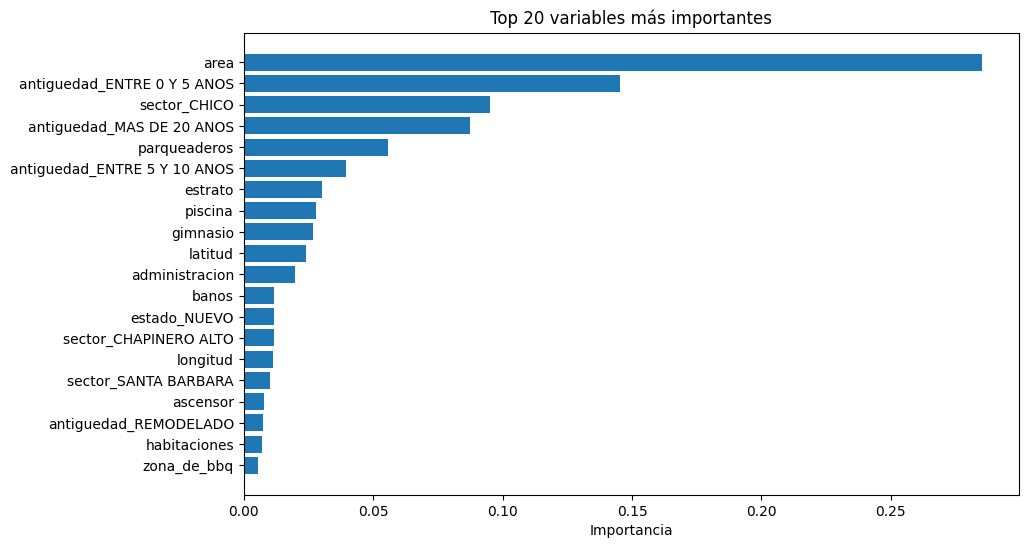

In [37]:
import matplotlib.pyplot as plt

# Extraer el modelo entrenado y el preprocesador
xgb_model = model.named_steps['regressor']
preprocessor = model.named_steps['preprocessor']

# Conseguir nombres de las features después del preprocesamiento
# numéricas
num_features_out = num_features
# binarias
bin_features_out = binary_features
# categóricas (one-hot)
cat_features_out = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_features)

feature_names = np.concatenate([num_features_out, cat_features_out, bin_features_out])

# Importancias
importances = xgb_model.feature_importances_

# Crear DataFrame ordenado
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print(feat_imp.head(15))

# (opcional) Graficar
plt.figure(figsize=(10,6))
plt.barh(feat_imp.head(20)['feature'][::-1], feat_imp.head(20)['importance'][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 variables más importantes")
plt.show()


## Prueba de modelo con (log)

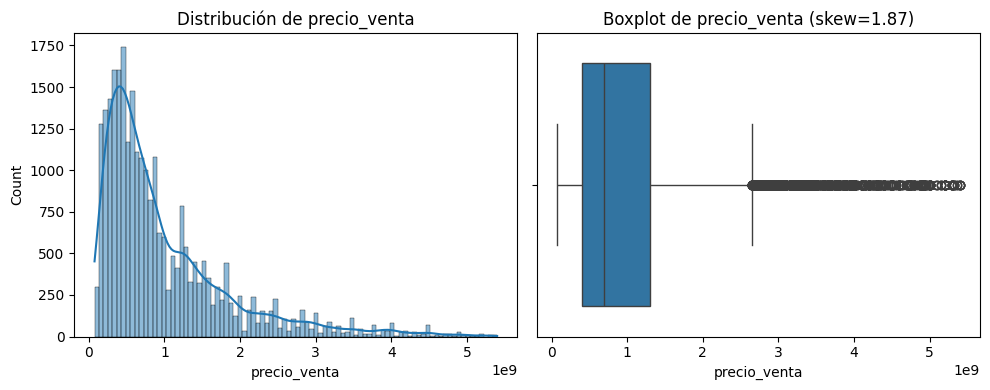

precio_venta: skewness = 1.87


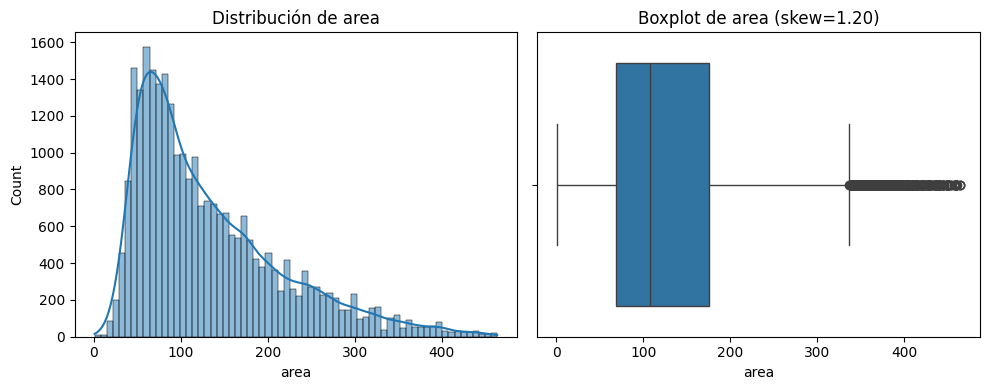

area: skewness = 1.20


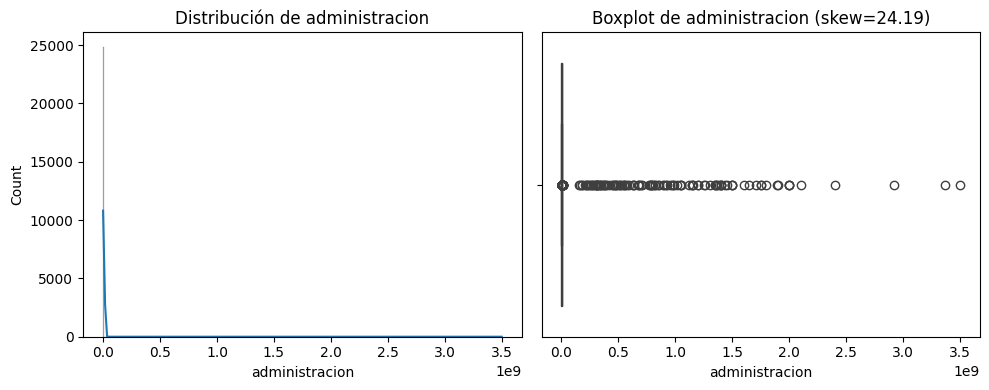

administracion: skewness = 24.19


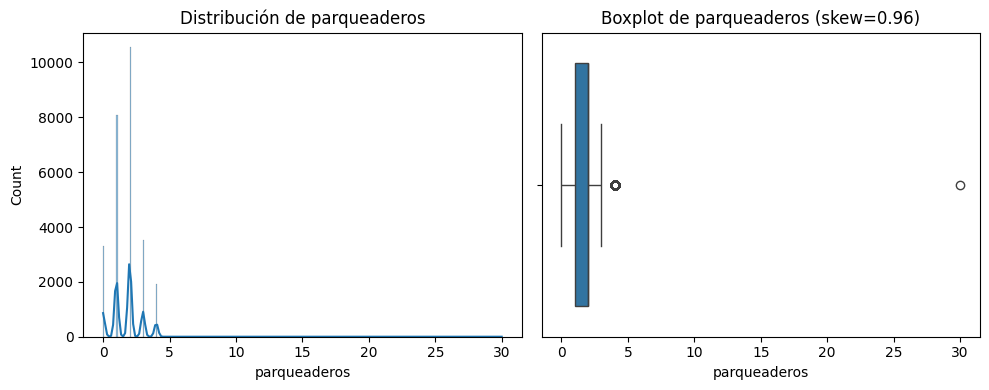

parqueaderos: skewness = 0.96


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecciona tus variables numéricas continuas
vars_continuas = ["precio_venta", "area", "administracion", "parqueaderos"]

for var in vars_continuas:
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(df[var].dropna(), kde=True)
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)

    plt.subplot(1,2,2)
    # calcular skewness
    skewness = df[var].dropna().skew()
    sns.boxplot(x=df[var])
    plt.title(f"Boxplot de {var} (skew={skewness:.2f})")
    plt.xlabel(var)

    plt.tight_layout()
    plt.show()

    print(f"{var}: skewness = {skewness:.2f}")

In [39]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

# Definir target y features
target_log = np.log1p(df["precio_venta"])
features_bog = df.drop(columns=["precio_venta"])

# Definir tipos de variables
num_features_log = ["area", "administracion"]
num_features_raw = ["habitaciones", "banos", "parqueaderos", "estrato", "latitud", "longitud"]
cat_features = ["sector", "estado", "antiguedad"]
binary_features = ["alarma", "ascensor", "conjunto_cerrado", "gimnasio", "piscina", "zona_de_bbq"]

# Separar conjunto de validación final
X_train_bog, X_val_bog, y_train_bog, y_val_bog = train_test_split(
    features_bog, target_log, test_size=0.15, random_state=42)

# Preprocesadores
log_transformer_bog = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("log", FunctionTransformer(np.log1p))
])

num_transformer_bog = SimpleImputer(strategy="median")

cat_transformer_bog = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="desconocido")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_bog = ColumnTransformer(
    transformers=[
        ("num_log", log_transformer_bog, num_features_log),
        ("num", num_transformer_bog, num_features_raw),
        ("cat", cat_transformer_bog, cat_features),
        ("bin", "passthrough", binary_features)
    ]
)

# Pipeline completo
pipeline_bog = Pipeline([
    ("preprocessor", preprocessor_bog),
    ("regressor", XGBRegressor(random_state=42, n_jobs=-1))
])

# Validación cruzada sobre entrenamiento
kf_bog = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores_bog = -cross_val_score(pipeline_bog, X_train_bog, y_train_bog, cv=kf_bog, scoring="neg_root_mean_squared_error")
mae_scores_bog = -cross_val_score(pipeline_bog, X_train_bog, y_train_bog, cv=kf_bog, scoring="neg_mean_absolute_error")
r2_scores_bog = cross_val_score(pipeline_bog, X_train_bog, y_train_bog, cv=kf_bog, scoring="r2")

print("\n===== Validación cruzada (k=5) =====")
print(f"RMSE promedio (log): {rmse_scores_bog.mean():.4f}")
print(f"MAE promedio (log): {mae_scores_bog.mean():.4f}")
print(f"R² promedio: {r2_scores_bog.mean():.3f}")

# Entrenar modelo final y evaluar en validación final
pipeline_bog.fit(X_train_bog, y_train_bog)
y_pred_log_bog = pipeline_bog.predict(X_val_bog)

# Deshacer la transformación log(1+x) para interpretar
y_val_real_bog = np.expm1(y_val_bog)
y_pred_real_bog = np.expm1(y_pred_log_bog)

# Verificación y RMSE manual
print("\n===== Verificación de valores =====")
print("NaNs en y_val_real:", np.isnan(y_val_real_bog).sum(), ", NaNs en y_pred_real:", np.isnan(y_pred_real_bog).sum())
print("Máximo y_val_real:", np.max(y_val_real_bog), ", Máximo y_pred_real:", np.max(y_pred_real_bog))
print("Mínimo y_val_real:", np.min(y_val_real_bog), ", Mínimo y_pred_real:", np.min(y_pred_real_bog))

rmse_final_bog = np.sqrt(np.mean((y_val_real_bog - y_pred_real_bog)**2))
mae_final_bog = mean_absolute_error(y_val_real_bog, y_pred_real_bog)
r2_final_bog = r2_score(y_val_real_bog, y_pred_real_bog)

print("\n===== Evaluación en conjunto de validación final =====")
print(f"RMSE: {rmse_final_bog:,.0f}")
print(f"MAE: {mae_final_bog:,.0f}")
print(f"R²: {r2_final_bog:.3f}")


===== Validación cruzada (k=5) =====
RMSE promedio (log): 0.1665
MAE promedio (log): 0.1219
R² promedio: 0.958

===== Verificación de valores =====
NaNs en y_val_real: 0 , NaNs en y_pred_real: 0
Máximo y_val_real: 5400000000.000001 , Máximo y_pred_real: 5.0074675e+09
Mínimo y_val_real: 80999999.99999987 , Mínimo y_pred_real: 8.178298e+07

===== Evaluación en conjunto de validación final =====
RMSE: 242,250,522
MAE: 133,172,318
R²: 0.919
